In [8]:
import bt
import pandas

In [9]:
import talib as ta

In [10]:
import dtale

In [11]:
class WeighTarget(bt.Algo):
    """
    Sets target weights based on a target weight DataFrame.

    Args:
        * target_weights (DataFrame): DataFrame containing the target weights

    Sets:
        * weights

    """

    def __init__(self, target_weights):
        self.tw = target_weights

    def __call__(self, target):
        # get target weights on date target.now
        if target.now in self.tw.index:
            w = self.tw.loc[target.now]

            # save in temp - this will be used by the weighing algo
            # also dropping any na's just in case they pop up
            target.temp['weights'] = w.dropna()

        # return True because we want to keep on moving down the stack
        return True

In [12]:
## download some data & calc SMAs
data = bt.get('spy', start='2010-01-01')

In [13]:
sma50 = data.rolling(50).mean()
sma200 = data.rolling(200).mean()

## now we need to calculate our target weight DataFrame
# first we will copy the sma200 DataFrame since our weights will have the same strucutre
tw = sma200.copy()

In [14]:
tw

,spy
Date,
2010-01-04,NaN
2010-01-05,NaN
2010-01-06,NaN
2010-01-07,NaN
2010-01-08,NaN
...,...
2024-05-13,468.829115
2024-05-14,469.185262
2024-05-15,469.569504


In [15]:
# set appropriate target weights
tw[sma50 > sma200] = 1.0
tw[sma50 <= sma200] = -1.0
# here we will set the weight to 0 - this is because the sma200 needs 200 data points before
# calculating its first point. Therefore, it will start with a bunch of nulls (NaNs).
tw[sma200.isnull()] = 0.0

In [21]:
tw

,spy
Date,
2010-01-04,0.0
2010-01-05,0.0
2010-01-06,0.0
2010-01-07,0.0
2010-01-08,0.0
...,...
2024-05-13,1.0
2024-05-14,1.0
2024-05-15,1.0


In [14]:
tw

,spy
Date,
2010-01-04,0.000000
2010-01-05,0.000000
2010-01-06,0.000000
2010-01-07,0.000000
2010-01-08,0.000000
...,...
2024-05-13,62.446631
2024-05-14,64.730346
2024-05-15,1.000000


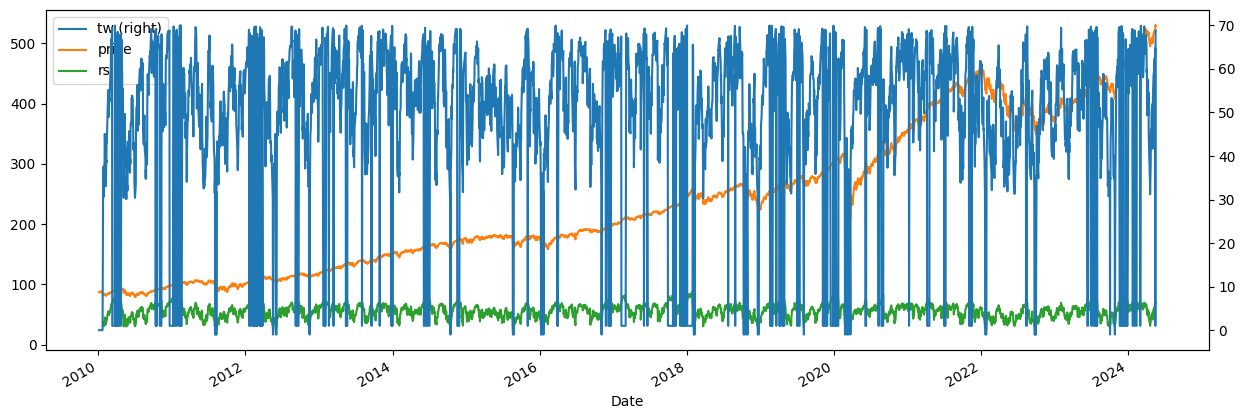

In [9]:
# plot the target weights + chart of price & SMAs
tmp = bt.merge(tw, data, rsi)
tmp.columns = ['tw', 'price', 'rsi']
ax = tmp.plot(figsize=(15,5), secondary_y=['tw'])

In [10]:
ma_cross = bt.Strategy('ma_cross', [WeighTarget(tw),
                                    bt.algos.Rebalance()])

t = bt.Backtest(ma_cross, data)
res = bt.run(t)

/Users/zlying/opt/miniconda3/envs/py310/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning:

invalid value encountered in log

/Users/zlying/opt/miniconda3/envs/py310/lib/python3.10/site-packages/ffn/core.py:1351: RuntimeWarning:

invalid value encountered in scalar power

/Users/zlying/opt/miniconda3/envs/py310/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning:

invalid value encountered in log

/Users/zlying/opt/miniconda3/envs/py310/lib/python3.10/site-packages/ffn/core.py:1351: RuntimeWarning:

invalid value encountered in scalar power



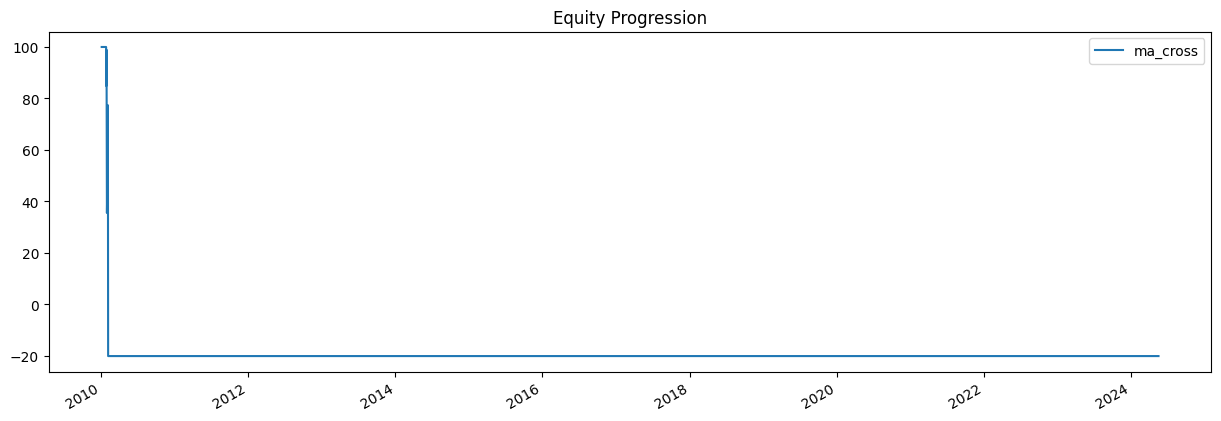

In [11]:
res.plot();

In [12]:
res.display()

Stat                 ma_cross
-------------------  ----------
Start                2010-01-03
End                  2024-05-17
Risk-free rate       0.00%

Total Return         -120.04%
Daily Sharpe         -0.23
Daily Sortino        -0.25
CAGR                 -
Max Drawdown         -120.04%
Calmar Ratio         -

MTD                  0.00%
3m                   0.00%
6m                   0.00%
YTD                  0.00%
1Y                   0.00%
3Y (ann.)            0.00%
5Y (ann.)            0.00%
10Y (ann.)           0.00%
Since Incep. (ann.)  -

Daily Sharpe         -0.23
Daily Sortino        -0.25
Daily Mean (ann.)    -9.69%
Daily Vol (ann.)     43.00%
Daily Skew           -31.92
Daily Kurt           1704.52
Best Day             47.72%
Worst Day            -133.37%

Monthly Sharpe       -0.26
Monthly Sortino      -0.26
Monthly Mean (ann.)  -10.91%
Monthly Vol (ann.)   41.31%
Monthly Skew         -13.11
Monthly Kurt         172.00
Best Month           0.00%
Worst Month          -156